In [2]:
!pip install deepctr[gpu]

     |████████████████████████████████| 112kB 9.0MB/s 
     |████████████████████████████████| 320.4MB 56kB/s 


In [25]:
# 모듈 불러오기
import os
os.chdir('/content/drive/My Drive/Big-Contest')

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, get_feature_names

import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

In [2]:
# 데이터 로드
# data = pd.read_csv("./data/범주데이터모음.csv", usecols=lambda x: 'Unnamed' not in x)
data = pd.read_csv("/content/drive/Shared drives/빅콘테스트/데이터(전처리 후 논의 대상)/범주데이터모음2.csv", usecols=lambda x: 'Unnamed' not in x)
# data_AMT = pd.read_csv("/content/drive/Shared drives/빅콘테스트/데이터(전처리 후 논의 대상)/카테고리1차데이터.csv", usecols=lambda x: 'Unnamed' not in x)

# 컬럼 확인

 총 23개. 매핑되어 있는 값들 쓰면 된다. 일단 카테고리화한 데이터에 VarLenSparseFeat, DenseFeat는 없다.


1. SparseFeat: LabelEncoder를 이용해 `int` 형태의 범주로 바꿔 주어야 한다. (맵핑된 값 쓰면 됨.)
2. VarLenSparseFeat: Multivalue Sparse Feat
3. DenseFeat:

In [3]:
# 컬럼 확인
len(data.columns), data.columns

(47,
 Index(['취급액', '요일', '시간', '월', '고유상품명', '계절', '노출횟수', '주의보bin3', '주의보bin4',
        '주의보유무', '경보유무', '일별강수량sum_cat', '일별적설sum_cat', '일별기온평균1', '일별기온최대1',
        '일별기온최소1', '일별기온평균2', '일별기온최대2', '일별기온최소2', '일교차1', '일별습도평균1',
        '일별습도평균2', '일별습도최대2', '일조량1', '요일 맵핑', '시간 맵핑', '월 맵핑', '고유상품명 맵핑',
        '계절 맵핑', '노출횟수 맵핑', '주의보bin3 맵핑', '주의보bin4 맵핑', '주의보유무 맵핑', '경보유무 맵핑',
        '일별강수량sum_cat 맵핑', '일별적설sum_cat 맵핑', '일별기온평균1 맵핑', '일별기온최대1 맵핑',
        '일별기온최소1 맵핑', '일별기온평균2 맵핑', '일별기온최대2 맵핑', '일별기온최소2 맵핑', '일교차1 맵핑',
        '일별습도평균1 맵핑', '일별습도평균2 맵핑', '일별습도최대2 맵핑', '일조량1 맵핑'],
       dtype='object'))

In [4]:
# 범주화를 위한 데이터
df = data[[x for x in data.columns if '맵핑' in x or x == '취급액']]
df.head()

,취급액,요일 맵핑,시간 맵핑,월 맵핑,고유상품명 맵핑,계절 맵핑,노출횟수 맵핑,주의보bin3 맵핑,주의보bin4 맵핑,주의보유무 맵핑,경보유무 맵핑,일별강수량sum_cat 맵핑,일별적설sum_cat 맵핑,일별기온평균1 맵핑,일별기온최대1 맵핑,일별기온최소1 맵핑,일별기온평균2 맵핑,일별기온최대2 맵핑,일별기온최소2 맵핑,일교차1 맵핑,일별습도평균1 맵핑,일별습도평균2 맵핑,일별습도최대2 맵핑,일조량1 맵핑
0,12033000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20663000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,47878000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,99736000,0,2,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,90973000,0,3,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# 컬럼 이름 영어로 변환
df.columns = ['AMT', 'day', 'hour', 'month', 'product_name', 'season', 'exposure_cnt', 'warning_1', 'warning_2', 'warning_3', 'warning_4', \
              'daily_precipitation_sum', 'daily_snow_sum', 'daily_temp_mean', 'daily_temp_max', 'daily_temp_min', 'daily_temp_mean_2', 'daily_temp_max_2', 'daily_temp_min_2', \
              'daily_temp_diff', 'daily_humidity_mean_1', 'daily_humidity_mean_2', 'daily_humidity_max_2', 'daily_sunshine']
df.head()

,AMT,day,hour,month,product_name,season,exposure_cnt,warning_1,warning_2,warning_3,warning_4,daily_precipitation_sum,daily_snow_sum,daily_temp_mean,daily_temp_max,daily_temp_min,daily_temp_mean_2,daily_temp_max_2,daily_temp_min_2,daily_temp_diff,daily_humidity_mean_1,daily_humidity_mean_2,daily_humidity_max_2,daily_sunshine
0,12033000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20663000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,47878000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,99736000,0,2,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,90973000,0,3,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 모델링(여기는 보지 말 것)

In [6]:
# MAPE 산식
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
# feature, target 정의
sparse_features = list(df.columns)[1:]
target = ['AMT']

In [9]:
# feature column 정의
fixlen_feature_columns = [SparseFeat(feat, df[feat].nunique(), embedding_dim=6) \
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
print(fixlen_feature_columns)
print(feature_names)

[SparseFeat(name='day', vocabulary_size=7, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fd161fd8588>, embedding_name='day', group_name='default_group', trainable=True), SparseFeat(name='hour', vocabulary_size=21, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fd11346e2e8>, embedding_name='hour', group_name='default_group', trainable=True), SparseFeat(name='month', vocabulary_size=12, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fd11346e470>, embedding_name='month', group_name='default_group', trainable=True), SparseFeat(name='product_name', vocabulary_size=956, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initial

In [11]:
# 트레인, 테스트 셋 분리
X_train, X_test, y_train, y_test = train_test_split(df[sparse_features], df[target],
                                                    test_size=0.2, random_state=2020)

# 입력 데이터
X_train = {name:X_train[name].values for name in feature_names}
X_test = {name:X_test[name].values for name in feature_names}
X_train

{'daily_humidity_max_2': array([7, 0, 7, ..., 6, 2, 8]),
 'daily_humidity_mean_1': array([15,  1, 11, ..., 10,  3, 14]),
 'daily_humidity_mean_2': array([7, 0, 7, ..., 6, 2, 8]),
 'daily_precipitation_sum': array([0, 0, 0, ..., 4, 1, 4]),
 'daily_snow_sum': array([0, 0, 0, ..., 0, 0, 0]),
 'daily_sunshine': array([5, 0, 5, ..., 4, 0, 6]),
 'daily_temp_diff': array([6, 1, 6, ..., 5, 0, 7]),
 'daily_temp_max': array([18,  4, 19, ..., 10,  3, 15]),
 'daily_temp_max_2': array([10,  2, 10, ...,  6,  1,  9]),
 'daily_temp_mean': array([19,  4, 19, ..., 11,  2, 15]),
 'daily_temp_mean_2': array([10,  2, 10, ...,  7,  2,  9]),
 'daily_temp_min': array([19,  2, 19, ..., 12,  2, 16]),
 'daily_temp_min_2': array([10,  2, 10, ...,  7,  2,  9]),
 'day': array([1, 4, 1, ..., 3, 4, 2]),
 'exposure_cnt': array([74, 10, 74, ..., 36, 33,  7]),
 'hour': array([15,  7, 16, ...,  3,  4, 17]),
 'month': array([ 9,  1, 10, ...,  6, 11,  8]),
 'product_name': array([473,  12, 473, ..., 491, 914, 647]),
 'seas

In [12]:
# 모델 학습
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile('adam', 'mape', metrics=['mape'], )
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
day (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
hour (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
product_name (InputLayer)       [(None, 1)]          0                                            
_______________________________________________________________________________________

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


34/34 - 1s - loss: 273759.9375 - mape: 273759.9375 - val_loss: 242407.0938 - val_mape: 242407.0938
Epoch 2/100
34/34 - 1s - loss: 281137.4062 - mape: 281137.4062 - val_loss: 195783.5625 - val_mape: 195783.5625
Epoch 3/100
34/34 - 1s - loss: 324369.8438 - mape: 324369.8438 - val_loss: 396055.8750 - val_mape: 396055.8750
Epoch 4/100
34/34 - 1s - loss: 367387.3750 - mape: 367387.3750 - val_loss: 177540.5938 - val_mape: 177540.6094
Epoch 5/100
34/34 - 1s - loss: 295853.2812 - mape: 295853.2812 - val_loss: 293933.3750 - val_mape: 293933.3750
Epoch 6/100
34/34 - 1s - loss: 294603.1250 - mape: 294603.1250 - val_loss: 334110.4375 - val_mape: 334110.4375
Epoch 7/100
34/34 - 1s - loss: 314182.7188 - mape: 314182.7188 - val_loss: 359846.2812 - val_mape: 359846.2812
Epoch 8/100
34/34 - 1s - loss: 414260.1250 - mape: 414260.1250 - val_loss: 276373.3750 - val_mape: 276373.3750
Epoch 9/100
34/34 - 1s - loss: 276474.9062 - mape: 276474.9062 - val_loss: 240148.6719 - val_mape: 240148.6719
Epoch 10/100


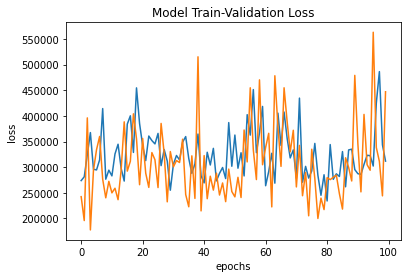

In [14]:
# 모델 훈련
hist = model.fit(X_train, y_train,
                 batch_size=256,
                 epochs=100,
                 verbose=2,
                 validation_split=0.2)

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model Train-Validation Loss')
plt.show()

# 취급액 0 제외 다시 모델링


In [29]:
# 데이터 준비
df = data[[x for x in data.columns if '맵핑' in x or x == '취급액']]
df = df.loc[df['취급액'] != 0]

# 컬럼 이름 영어로 변환
df.columns = ['AMT', 'day', 'hour', 'month', 'product_name', 'season', 'exposure_cnt', 'warning_1', 'warning_2', 'warning_3', 'warning_4', \
              'daily_precipitation_sum', 'daily_snow_sum', 'daily_temp_mean', 'daily_temp_max', 'daily_temp_min', 'daily_temp_mean_2', 'daily_temp_max_2', 'daily_temp_min_2', \
              'daily_temp_diff', 'daily_humidity_mean_1', 'daily_humidity_mean_2', 'daily_humidity_max_2', 'daily_sunshine']

In [30]:
# feature, target 정의
sparse_features = list(df.columns)[1:]
target = ['AMT']

# feature column 정의
fixlen_feature_columns = [SparseFeat(feat, df[feat].nunique(), embedding_dim=6) \
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
print(fixlen_feature_columns)
print(feature_names)

[SparseFeat(name='day', vocabulary_size=7, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fd09639a240>, embedding_name='day', group_name='default_group', trainable=True), SparseFeat(name='hour', vocabulary_size=21, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fd09639a1d0>, embedding_name='hour', group_name='default_group', trainable=True), SparseFeat(name='month', vocabulary_size=12, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fd09639a320>, embedding_name='month', group_name='default_group', trainable=True), SparseFeat(name='product_name', vocabulary_size=956, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initial

In [31]:
# 트레인, 테스트 셋 분리
X_train, X_test, y_train, y_test = train_test_split(df[sparse_features], df[target],
                                                    test_size=0.2, random_state=2020)

# 입력 데이터
X_train = {name:X_train[name].values for name in feature_names}
X_test = {name:X_test[name].values for name in feature_names}

Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


33/33 [==============================] - 1s 43ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 2/500
33/33 [==============================] - 1s 21ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 3/500
33/33 [==============================] - 1s 21ms/step - loss: 100.0000 - val_loss: 99.9999
Epoch 4/500
33/33 [==============================] - 1s 21ms/step - loss: 99.9999 - val_loss: 99.9998
Epoch 5/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9996 - val_loss: 99.9994
Epoch 6/500
33/33 [==============================] - 1s 21ms/step - loss: 99.9990 - val_loss: 99.9985
Epoch 7/500
33/33 [==============================] - 1s 22ms/step - loss: 99.9976 - val_loss: 99.9966
Epoch 8/500
33/33 [==============================] - 1s 21ms/step - loss: 99.9951 - val_loss: 99.9935
Epoch 9/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9908 - val_loss: 99.9883
Epoch 10/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9845 - val_

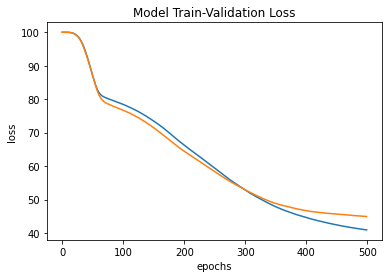

In [35]:
K.clear_session()

# 모델 학습
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
# model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mape')
model.compile(optimizers.RMSprop(learning_rate=0.001), loss='mape')

# 모델 훈련
hist = model.fit(X_train, y_train,
                 batch_size=256,
                 epochs=500,
                 verbose=1,
                 validation_split=0.2)

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model Train-Validation Loss')
plt.show()

### adam이 더 빨리 떨어진다.

Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


33/33 [==============================] - 1s 40ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 3/500
33/33 [==============================] - 1s 19ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 4/500
33/33 [==============================] - 1s 19ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 5/500
33/33 [==============================] - 1s 19ms/step - loss: 100.0000 - val_loss: 99.9999
Epoch 6/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9999 - val_loss: 99.9999
Epoch 7/500
33/33 [==============================] - 1s 19ms/step - loss: 99.9996 - val_loss: 99.9992
Epoch 8/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9977 - val_loss: 99.9951
Epoch 9/500
33/33 [==============================] - 1s 19ms/step - loss: 99.9884 - val_loss: 99.9780
Epoch 10/500
33/33 [==============================] - 1s 19ms/step - loss: 99.9572 - 

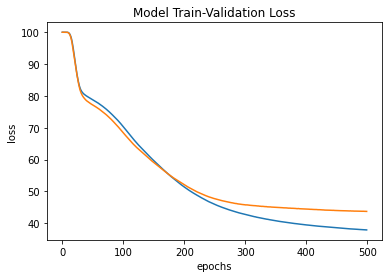

In [27]:
K.clear_session()

# 모델 학습
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mape')
# model.compile(optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.1)) # 안 좋음.

# 모델 훈련
hist = model.fit(X_train, y_train,
                 batch_size=256,
                 epochs=500,
                 verbose=1,
                 validation_split=0.2)

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model Train-Validation Loss')
plt.show()